In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_ch_128_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=128, strides=1, padding='same', input_shape=input_shape)) 
    model.add(BatchNormalization())
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=128*(2**int((i+1)/4)), 
                          strides=1, padding='same'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(3, 10):
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 16000, 128)        512       
_________________________________________________________________
activation (Activation)      (None, 16000, 128)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 16000, 128)        512       
_________________________________________________________________
activation_1 (Activat

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_12 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_12 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_13 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_13 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 5333, 128)         0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_33 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_33 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_33 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_34 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_34 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 5333, 128)         0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.8650 - acc: 0.3099
Epoch 00001: val_loss improved from inf to 2.02650, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_3_conv_checkpoint/001-2.0265.hdf5
36805/36805 [==============================] - 177s 5ms/sample - loss: 2.8652 - acc: 0.3099 - val_loss: 2.0265 - val_acc: 0.3953
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0108 - acc: 0.4666
Epoch 00002: val_loss did not improve from 2.02650
36805/36805 [==============================] - 173s 5ms/sample - loss: 2.0109 - acc: 0.4666 - val_loss: 2.0640 - val_acc: 0.4547
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6875 - acc: 0.5402
Epoch 00003: val_loss improved from 2.02650 to 1.48894, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_3_conv_checkpoint/003-1.4889.h

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2950 - acc: 0.9124
Epoch 00029: val_loss did not improve from 1.48894
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.2951 - acc: 0.9123 - val_loss: 1.6665 - val_acc: 0.6730
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2747 - acc: 0.9162
Epoch 00030: val_loss did not improve from 1.48894
36805/36805 [==============================] - 173s 5ms/sample - loss: 0.2749 - acc: 0.9162 - val_loss: 1.7173 - val_acc: 0.6744
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2566 - acc: 0.9231
Epoch 00031: val_loss did not improve from 1.48894
36805/36805 [==============================] - 174s 5ms/sample - loss: 0.2567 - acc: 0.9231 - val_loss: 2.0388 - val_acc: 0.6201
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2535 - acc: 0.9237
Epoch 00032: val_loss did not improve from 1.48894
36805/36805 [========

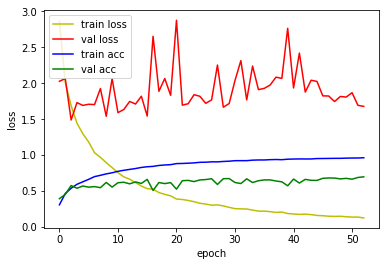

4815/4815 [==============================] - 8s 2ms/sample - loss: 1.6511 - acc: 0.5693
Loss: 1.6511325706697821 Accuracy: 0.56926274

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5895 - acc: 0.3242
Epoch 00001: val_loss improved from inf to 1.61345, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_4_conv_checkpoint/001-1.6134.hdf5
36805/36805 [==============================] - 186s 5ms/sample - loss: 2.5897 - acc: 0.3242 - val_loss: 1.6134 - val_acc: 0.4894
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6456 - acc: 0.5124
Epoch 00002: val_loss improved from 1.61345 to 1.23194, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_4_conv_checkpoint/002-1.2319.hdf5
36805/36805 [==============================] - 182s 5ms/sample - loss: 1.6458 - acc: 0.5124 - val_loss: 1.2319 - val_acc: 0.6191
Epoch 3/500
36800/36805 [============================>.]

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3774 - acc: 0.8793
Epoch 00027: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.3775 - acc: 0.8793 - val_loss: 0.7904 - val_acc: 0.7939
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3610 - acc: 0.8832
Epoch 00028: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.3609 - acc: 0.8832 - val_loss: 0.8562 - val_acc: 0.7815
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3529 - acc: 0.8835
Epoch 00029: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.3529 - acc: 0.8835 - val_loss: 0.8178 - val_acc: 0.7894
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3442 - acc: 0.8870
Epoch 00030: val_loss did not improve from 0.75001
36805/36805 [========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1638 - acc: 0.9486
Epoch 00057: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1638 - acc: 0.9486 - val_loss: 0.8391 - val_acc: 0.8095
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1713 - acc: 0.9448
Epoch 00058: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1713 - acc: 0.9448 - val_loss: 0.8471 - val_acc: 0.8083
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1664 - acc: 0.9469
Epoch 00059: val_loss did not improve from 0.75001
36805/36805 [==============================] - 182s 5ms/sample - loss: 0.1665 - acc: 0.9468 - val_loss: 0.9366 - val_acc: 0.7913
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1665 - acc: 0.9463
Epoch 00060: val_loss did not improve from 0.75001
36805/36805 [========

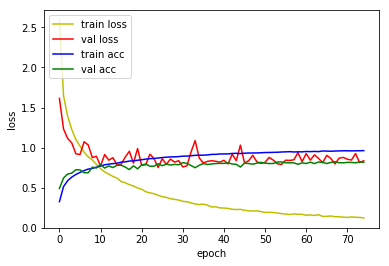

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.8928 - acc: 0.7583
Loss: 0.8927627567685406 Accuracy: 0.7582554

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6300 - acc: 0.3294
Epoch 00001: val_loss improved from inf to 1.66399, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_5_conv_checkpoint/001-1.6640.hdf5
36805/36805 [==============================] - 194s 5ms/sample - loss: 2.6298 - acc: 0.3295 - val_loss: 1.6640 - val_acc: 0.4542
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5923 - acc: 0.5441
Epoch 00002: val_loss improved from 1.66399 to 1.31332, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_5_conv_checkpoint/002-1.3133.hdf5
36805/36805 [==============================] - 189s 5ms/sample - loss: 1.5925 - acc: 0.5440 - val_loss: 1.3133 - val_acc: 0.6110
Epoch 3/500
36800/36805 [============================>.] 

36800/36805 [============================>.] - ETA: 0s - loss: 0.3893 - acc: 0.8757
Epoch 00026: val_loss did not improve from 0.56232
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.3893 - acc: 0.8757 - val_loss: 0.5867 - val_acc: 0.8418
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3683 - acc: 0.8837
Epoch 00027: val_loss did not improve from 0.56232
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.3687 - acc: 0.8836 - val_loss: 0.6495 - val_acc: 0.8332
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3743 - acc: 0.8829
Epoch 00028: val_loss did not improve from 0.56232
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.3743 - acc: 0.8829 - val_loss: 0.5996 - val_acc: 0.8388
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3548 - acc: 0.8886
Epoch 00029: val_loss improved from 0.56232 to 0.56154, saving model to model/checkpo

36800/36805 [============================>.] - ETA: 0s - loss: 0.1727 - acc: 0.9438
Epoch 00054: val_loss did not improve from 0.51572
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.1728 - acc: 0.9438 - val_loss: 0.6213 - val_acc: 0.8607
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1724 - acc: 0.9434
Epoch 00055: val_loss did not improve from 0.51572
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.1724 - acc: 0.9434 - val_loss: 0.5945 - val_acc: 0.8588
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1634 - acc: 0.9459
Epoch 00056: val_loss did not improve from 0.51572
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.1634 - acc: 0.9459 - val_loss: 0.5460 - val_acc: 0.8714
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1605 - acc: 0.9484
Epoch 00057: val_loss did not improve from 0.51572
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1079 - acc: 0.9656
Epoch 00084: val_loss did not improve from 0.51572
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.1079 - acc: 0.9656 - val_loss: 0.7313 - val_acc: 0.8435
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0957 - acc: 0.9692
Epoch 00085: val_loss did not improve from 0.51572
36805/36805 [==============================] - 188s 5ms/sample - loss: 0.0959 - acc: 0.9692 - val_loss: 0.5562 - val_acc: 0.8803

1D_CNN_custom_ch_128_DO_075_DO_BN_5_conv Model


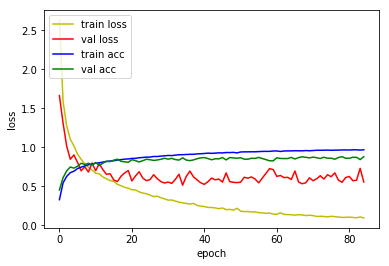

4815/4815 [==============================] - 8s 2ms/sample - loss: 0.6380 - acc: 0.8330
Loss: 0.6379768278120957 Accuracy: 0.8330218

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6868 - acc: 0.2865
Epoch 00001: val_loss improved from inf to 1.91749, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_6_conv_checkpoint/001-1.9175.hdf5
36805/36805 [==============================] - 199s 5ms/sample - loss: 2.6868 - acc: 0.2865 - val_loss: 1.9175 - val_acc: 0.3324
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5281 - acc: 0.5302
Epoch 00002: val_loss improved from 1.91749 to 1.05087, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_6_conv_checkpoint/002-1.0509.hdf5
36805/36805 [==============================] - 192s 5ms/sample - loss: 1.5282 - acc: 0.5302 - val_loss: 1.0509 - val_acc: 0.6753
Epoch 3/500
36800/36805 [============================>.] 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2922 - acc: 0.9101
Epoch 00025: val_loss did not improve from 0.34550
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.2922 - acc: 0.9101 - val_loss: 0.4313 - val_acc: 0.8898
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2798 - acc: 0.9117
Epoch 00026: val_loss did not improve from 0.34550
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.2799 - acc: 0.9117 - val_loss: 0.5691 - val_acc: 0.8500
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2772 - acc: 0.9135
Epoch 00027: val_loss did not improve from 0.34550
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.2772 - acc: 0.9135 - val_loss: 0.3512 - val_acc: 0.9031
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2671 - acc: 0.9158
Epoch 00028: val_loss did not improve from 0.34550
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1385 - acc: 0.9547
Epoch 00054: val_loss did not improve from 0.32523
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.1388 - acc: 0.9547 - val_loss: 0.3877 - val_acc: 0.9140
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1601 - acc: 0.9498
Epoch 00055: val_loss did not improve from 0.32523
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.1601 - acc: 0.9498 - val_loss: 0.3369 - val_acc: 0.9224
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1227 - acc: 0.9597
Epoch 00056: val_loss did not improve from 0.32523
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.1227 - acc: 0.9597 - val_loss: 0.3653 - val_acc: 0.9147
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1183 - acc: 0.9600
Epoch 00057: val_loss improved from 0.32523 to 0.31698, saving model to 

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0783 - acc: 0.9754
Epoch 00083: val_loss did not improve from 0.31099
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0784 - acc: 0.9754 - val_loss: 0.3786 - val_acc: 0.9182
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0784 - acc: 0.9744
Epoch 00084: val_loss did not improve from 0.31099
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0784 - acc: 0.9744 - val_loss: 0.3359 - val_acc: 0.9297
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0695 - acc: 0.9768
Epoch 00085: val_loss did not improve from 0.31099
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0696 - acc: 0.9768 - val_loss: 0.3868 - val_acc: 0.9238
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0786 - acc: 0.9739
Epoch 00086: val_loss did not improve from 0.31099
36805/36805 [========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0490 - acc: 0.9847
Epoch 00112: val_loss did not improve from 0.29557
36805/36805 [==============================] - 191s 5ms/sample - loss: 0.0490 - acc: 0.9847 - val_loss: 0.3557 - val_acc: 0.9280
Epoch 113/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0514 - acc: 0.9836
Epoch 00113: val_loss did not improve from 0.29557
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0515 - acc: 0.9835 - val_loss: 0.4621 - val_acc: 0.9066
Epoch 114/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0615 - acc: 0.9791
Epoch 00114: val_loss did not improve from 0.29557
36805/36805 [==============================] - 192s 5ms/sample - loss: 0.0615 - acc: 0.9791 - val_loss: 0.3942 - val_acc: 0.9180
Epoch 115/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0554 - acc: 0.9815
Epoch 00115: val_loss did not improve from 0.29557
36805/36805 [==================

Epoch 142/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0396 - acc: 0.9866
Epoch 00142: val_loss did not improve from 0.29557
36805/36805 [==============================] - 191s 5ms/sample - loss: 0.0396 - acc: 0.9866 - val_loss: 0.3938 - val_acc: 0.9297
Epoch 143/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0328 - acc: 0.9895
Epoch 00143: val_loss did not improve from 0.29557
36805/36805 [==============================] - 191s 5ms/sample - loss: 0.0333 - acc: 0.9894 - val_loss: 0.4796 - val_acc: 0.9215
Epoch 144/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9804
Epoch 00144: val_loss did not improve from 0.29557
36805/36805 [==============================] - 191s 5ms/sample - loss: 0.0636 - acc: 0.9804 - val_loss: 0.3343 - val_acc: 0.9359
Epoch 145/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0334 - acc: 0.9886
Epoch 00145: val_loss did not improve from 0.29557
36805/36805 [====

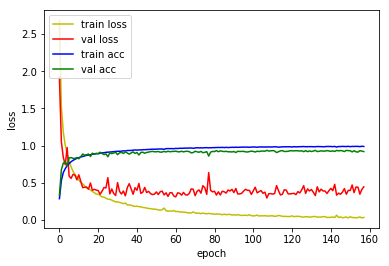

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.4392 - acc: 0.9076
Loss: 0.4391809105625529 Accuracy: 0.9075805

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.7064 - acc: 0.2674
Epoch 00001: val_loss improved from inf to 1.64350, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_7_conv_checkpoint/001-1.6435.hdf5
36805/36805 [==============================] - 204s 6ms/sample - loss: 2.7067 - acc: 0.2674 - val_loss: 1.6435 - val_acc: 0.4589
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5298 - acc: 0.5194
Epoch 00002: val_loss improved from 1.64350 to 0.86999, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_7_conv_checkpoint/002-0.8700.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 1.5298 - acc: 0.5194 - val_loss: 0.8700 - val_acc: 0.7445
Epoch 3/500
36800/36805 [============================>.] 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1792 - acc: 0.9426
Epoch 00026: val_loss improved from 0.20729 to 0.20641, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_7_conv_checkpoint/026-0.2064.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.1792 - acc: 0.9426 - val_loss: 0.2064 - val_acc: 0.9425
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1641 - acc: 0.9457
Epoch 00027: val_loss did not improve from 0.20641
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.1643 - acc: 0.9457 - val_loss: 0.2201 - val_acc: 0.9425
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1689 - acc: 0.9460
Epoch 00028: val_loss improved from 0.20641 to 0.19333, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_7_conv_checkpoint/028-0.1933.hdf5
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.1688 - acc: 0

36800/36805 [============================>.] - ETA: 0s - loss: 0.0853 - acc: 0.9726
Epoch 00054: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0853 - acc: 0.9726 - val_loss: 0.2469 - val_acc: 0.9429
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0677 - acc: 0.9781
Epoch 00055: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0677 - acc: 0.9781 - val_loss: 0.2472 - val_acc: 0.9392
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0640 - acc: 0.9789
Epoch 00056: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0640 - acc: 0.9789 - val_loss: 0.2541 - val_acc: 0.9429
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0635 - acc: 0.9786
Epoch 00057: val_loss did not improve from 0.18309
36805/36805 [=====================

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0467 - acc: 0.9847
Epoch 00084: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0467 - acc: 0.9847 - val_loss: 0.2333 - val_acc: 0.9488
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0306 - acc: 0.9899
Epoch 00085: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0306 - acc: 0.9899 - val_loss: 0.2260 - val_acc: 0.9576
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0338 - acc: 0.9883
Epoch 00086: val_loss did not improve from 0.18309
36805/36805 [==============================] - 193s 5ms/sample - loss: 0.0338 - acc: 0.9883 - val_loss: 0.2351 - val_acc: 0.9520
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0341 - acc: 0.9894
Epoch 00087: val_loss did not improve from 0.18309
36805/36805 [========

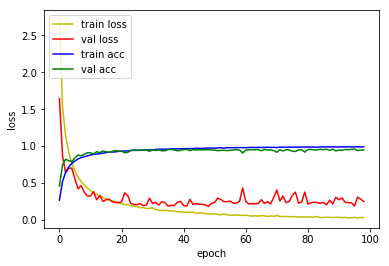

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2285 - acc: 0.9396
Loss: 0.22854622391092194 Accuracy: 0.9395639

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6853 - acc: 0.2932
Epoch 00001: val_loss improved from inf to 1.49243, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_8_conv_checkpoint/001-1.4924.hdf5
36805/36805 [==============================] - 210s 6ms/sample - loss: 2.6851 - acc: 0.2933 - val_loss: 1.4924 - val_acc: 0.4917
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4059 - acc: 0.5709
Epoch 00002: val_loss improved from 1.49243 to 0.68045, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_8_conv_checkpoint/002-0.6805.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 1.4058 - acc: 0.5709 - val_loss: 0.6805 - val_acc: 0.7971
Epoch 3/500
36800/36805 [============================>.]

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1014 - acc: 0.9676
Epoch 00025: val_loss did not improve from 0.12765
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.1014 - acc: 0.9676 - val_loss: 0.1831 - val_acc: 0.9502
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1033 - acc: 0.9666
Epoch 00026: val_loss did not improve from 0.12765
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.1033 - acc: 0.9666 - val_loss: 0.1422 - val_acc: 0.9623
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0925 - acc: 0.9701
Epoch 00027: val_loss did not improve from 0.12765
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0926 - acc: 0.9701 - val_loss: 0.1395 - val_acc: 0.9611
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9677
Epoch 00028: val_loss did not improve from 0.12765
36805/36805 [========

Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0300 - acc: 0.9910
Epoch 00054: val_loss did not improve from 0.12019
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0300 - acc: 0.9910 - val_loss: 0.1440 - val_acc: 0.9672
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9907
Epoch 00055: val_loss did not improve from 0.12019
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0287 - acc: 0.9907 - val_loss: 0.1825 - val_acc: 0.9599
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9905
Epoch 00056: val_loss did not improve from 0.12019
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0302 - acc: 0.9905 - val_loss: 0.2473 - val_acc: 0.9464
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0302 - acc: 0.9902
Epoch 00057: val_loss did not improve from 0.12019
36805/36805 [========

Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0154 - acc: 0.9953
Epoch 00084: val_loss did not improve from 0.12019
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0154 - acc: 0.9953 - val_loss: 0.2221 - val_acc: 0.9543
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0144 - acc: 0.9956
Epoch 00085: val_loss did not improve from 0.12019
36805/36805 [==============================] - 194s 5ms/sample - loss: 0.0144 - acc: 0.9956 - val_loss: 0.1409 - val_acc: 0.9686
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9957
Epoch 00086: val_loss did not improve from 0.12019
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0145 - acc: 0.9957 - val_loss: 0.1797 - val_acc: 0.9653
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0127 - acc: 0.9963
Epoch 00087: val_loss did not improve from 0.12019
36805/36805 [========

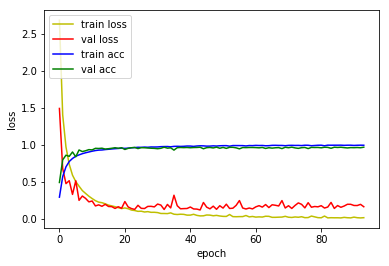

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1695 - acc: 0.9562
Loss: 0.1694656056089874 Accuracy: 0.9561786

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2728 - acc: 0.4305
Epoch 00001: val_loss improved from inf to 1.02150, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_9_conv_checkpoint/001-1.0215.hdf5
36805/36805 [==============================] - 215s 6ms/sample - loss: 2.2731 - acc: 0.4304 - val_loss: 1.0215 - val_acc: 0.6751
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.8923 - acc: 0.7383
Epoch 00002: val_loss improved from 1.02150 to 0.38842, saving model to model/checkpoint/1D_CNN_custom_ch_128_DO_075_DO_BN_9_conv_checkpoint/002-0.3884.hdf5
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.8924 - acc: 0.7382 - val_loss: 0.3884 - val_acc: 0.8856
Epoch 3/500
36800/36805 [============================>.] 

Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0546 - acc: 0.9832
Epoch 00026: val_loss did not improve from 0.11685
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0547 - acc: 0.9832 - val_loss: 0.1661 - val_acc: 0.9578
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9813
Epoch 00027: val_loss did not improve from 0.11685
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0578 - acc: 0.9813 - val_loss: 0.1290 - val_acc: 0.9653
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9844
Epoch 00028: val_loss did not improve from 0.11685
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0487 - acc: 0.9844 - val_loss: 0.1196 - val_acc: 0.9695
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9856
Epoch 00029: val_loss did not improve from 0.11685
36805/36805 [========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0157 - acc: 0.9951
Epoch 00055: val_loss did not improve from 0.11348
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0157 - acc: 0.9951 - val_loss: 0.1289 - val_acc: 0.9720
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0120 - acc: 0.9963
Epoch 00056: val_loss did not improve from 0.11348
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0123 - acc: 0.9963 - val_loss: 0.2005 - val_acc: 0.9571
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0353 - acc: 0.9895
Epoch 00057: val_loss did not improve from 0.11348
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0353 - acc: 0.9895 - val_loss: 0.1222 - val_acc: 0.9723
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0133 - acc: 0.9961
Epoch 00058: val_loss did not improve from 0.11348
36805/36805 [========

Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0145 - acc: 0.9957
Epoch 00085: val_loss did not improve from 0.11348
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0145 - acc: 0.9957 - val_loss: 0.1657 - val_acc: 0.9672
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0092 - acc: 0.9973
Epoch 00086: val_loss did not improve from 0.11348
36805/36805 [==============================] - 195s 5ms/sample - loss: 0.0093 - acc: 0.9972 - val_loss: 0.1570 - val_acc: 0.9641
Epoch 87/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0128 - acc: 0.9965
Epoch 00087: val_loss did not improve from 0.11348
36805/36805 [==============================] - 196s 5ms/sample - loss: 0.0128 - acc: 0.9965 - val_loss: 0.1249 - val_acc: 0.9716
Epoch 88/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0049 - acc: 0.9985
Epoch 00088: val_loss did not improve from 0.11348
36805/36805 [========

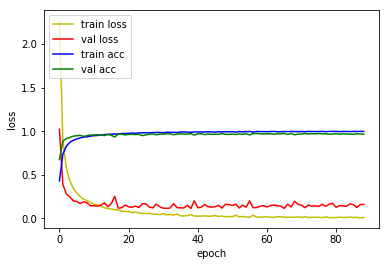

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.1614 - acc: 0.9605
Loss: 0.16137579948499195 Accuracy: 0.96054



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_ch_128_DO_075_DO_BN'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_ch_128_DO_BN(conv_num=i)

#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_ch_128_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_075_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.6380 - acc: 0.8330
Loss: 0.6379768278120957 Accuracy: 0.8330218

1D_CNN_custom_ch_128_DO_075_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_55 (Activation) 

4815/4815 [==============================] - 9s 2ms/sample - loss: 0.2285 - acc: 0.9396
Loss: 0.22854622391092194 Accuracy: 0.9395639

1D_CNN_custom_ch_128_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_68 (Activation)

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.1614 - acc: 0.9605
Loss: 0.16137579948499195 Accuracy: 0.96054


In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_ch_128_DO_075_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_42 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_42 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_43 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_43 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
max_pooling1d_35 (MaxPooling

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.6856 - acc: 0.8449
Loss: 0.6855898995389572 Accuracy: 0.84485984

1D_CNN_custom_ch_128_DO_075_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_54 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_54 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_54 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_55 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_55 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_55 (Activation

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.3205 - acc: 0.9302
Loss: 0.3204554096947454 Accuracy: 0.93021804

1D_CNN_custom_ch_128_DO_075_DO_BN_8_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_67 (Conv1D)           (None, 16000, 128)        768       
_________________________________________________________________
batch_normalization_v1_67 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_67 (Activation)   (None, 16000, 128)        0         
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 16000, 128)        82048     
_________________________________________________________________
batch_normalization_v1_68 (B (None, 16000, 128)        512       
_________________________________________________________________
activation_68 (Activation

4815/4815 [==============================] - 10s 2ms/sample - loss: 0.2095 - acc: 0.9595
Loss: 0.2094678941997095 Accuracy: 0.95950156
